# Context Veracity

Datset and Notebook to Scrape data from Politifiact

Politifact scraped data is saved in '**NEWS.csv**' file. The scraping is done in a **separate notebook**.

Link for scraped Dataset : https://drive.google.com/file/d/1w3lAOZn5rMvuaEkMcs_9g4FKVmop_Udd/view?usp=sharing

Fake news can take on many forms, including photoshopped images, fake user-generated content or spoofed accounts, network-based content designed to appeal to a particular organization or group, as well as knowledge-based stories that contain a scientific or reasonable explanation of unresolved issues, often resulting in the spread of false information.


The factor chosen for Fake news detection is Context veracity. The dataset used is scrapped data from Politifact. Along with scraping the news addtional source information for the news is also scrapped.
To determince context veracity we need to find evidence for the news topic.

##Data Narrative

Misinformation detection, which has become an increasingly important topic in Natural Language Processing. Misinformation refers to the distribution of false information in the context of news. 

For this Assignment the Liar Liar Plus dataset is used. The Liar Liar Plus dataset provides information about the source of a news and the score count for the source. For each source it determines the number of False / Ture counts.
This information was not included in the original Liar Liar dataset. Hence in the Liar Liar plus dataset further analysis of the source is included.

Along with this Politifact scrapped data is also used. For each news post Politifact proiveds source information which is  also scrapped to gather relaibility of the source.

##Import Libraries

In [51]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [52]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import the Liar Liar Plus dataset

In [53]:
# Reading the tsv file into DataFrame


test_filename = '/content/drive/My Drive/Alternus_Vera/Context_Veracity_Sprint5/test2.tsv'
train_filename = '/content/drive/My Drive/Alternus_Vera/Context_Veracity_Sprint5/train2.tsv'
valid_filename = '/content/drive/My Drive/Alternus_Vera/Context_Veracity_Sprint5/val2.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytruecounts','pantsonfirecounts','context', 'text']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

In [54]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [55]:
# Dropping the 'id' column
train_news.drop('jsonid', axis = 1, inplace = True)
test_news.drop('jsonid', axis = 1, inplace = True)
valid_news.drop('jsonid', axis = 1, inplace = True)

In [56]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [57]:
# Checking the shape of data
print(train_news.shape)
print(valid_news.shape)
print(test_news.shape)

(10242, 14)
(1284, 14)
(1267, 14)


#Data Cleaning and Text Preprocessing#

As a part of cleaning, we will perform below steps:
1. Remove Special characters
2. Convert text to lower case
3. Tokenization
4. Removing stop words
5. Lemmetization
6. Stemming

In [58]:
import re

def cleaning(raw_text):
    import nltk
    
    # 1. Remove non-letters/Special Characters
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    
    # 2. Convert to lower case.
    text =  text.lower()
    
    # 3. Tokenize.
    text_words = nltk.word_tokenize(text)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  text_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [59]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean_text'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Time to clean, tokenize and stem train data: 
 10242 news: 0.09743602275848388 min


#Data Visualization#

In [60]:
# Final data present in datset after data preprocessing, and cleaning
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term


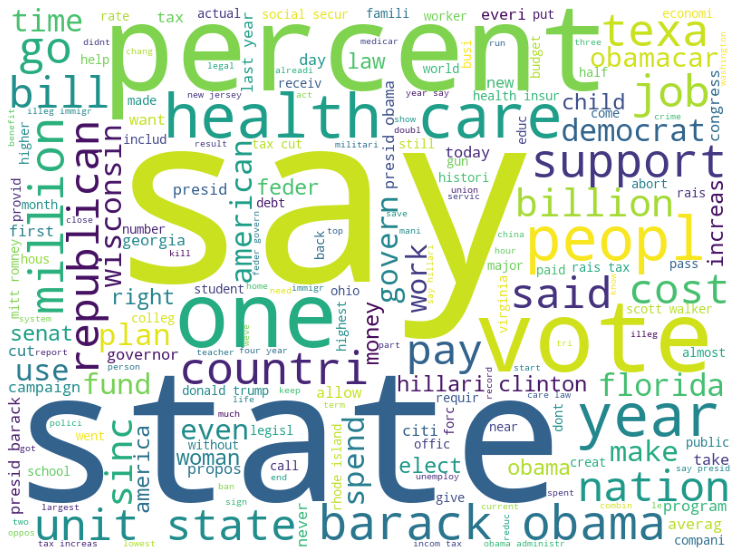

In [61]:
#Word cloud of Train dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(train_news['clean_text']))


##Prepare Test and Validation dataset

###Test Data

In [62]:
# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
test_news['clean_text'] = test_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem test data: 
 1267 news: 0.14933911561965943 min


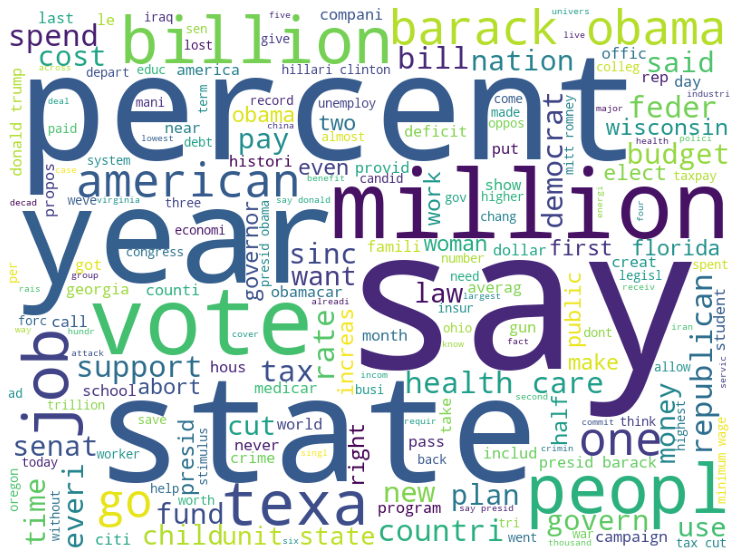

In [63]:
#Word cloud of Test dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(test_news['clean_text']))

###Validation Dataset

In [64]:
# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
valid_news['clean_text'] = valid_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem validation data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem validation data: 
 1267 news: 0.19170239369074504 min


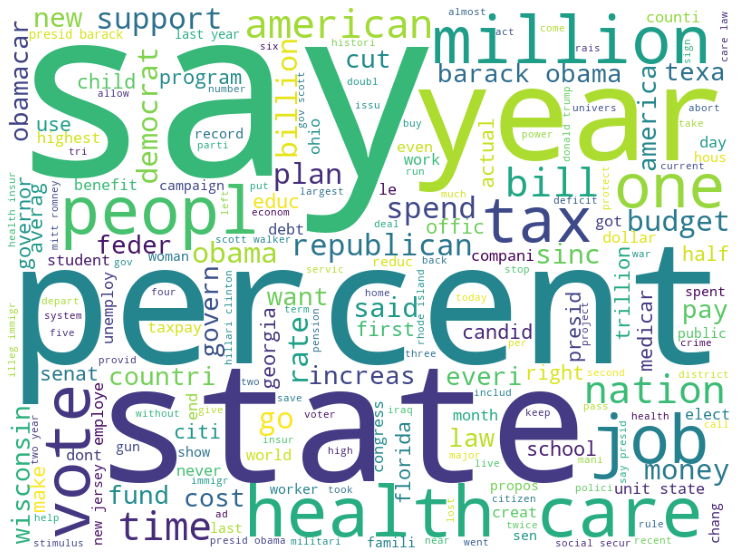

In [65]:
#Word cloud of Validation dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(valid_news['clean_text']))

In [66]:
#train_news = train_news.append(test_news).append(valid_news)

In [67]:
train_news.shape

(10242, 15)

#Verify Veracity 

In [68]:
#Find unique values for Label column
train_news.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire', nan], dtype=object)

In [69]:
#Check the total records in the Train dataset
train_news.shape

(10242, 15)

In [70]:
#As some of the Label values are 'NaN' lets drop records with 'NaN' as label value
train_news = train_news.dropna(subset=['label'])

There were 2 records with label as Nan which are dropped now

In [71]:
train_news.shape

(10240, 15)

In [72]:
train_news.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

Above are the 6 unique label values 

In [73]:
#Use Scikit learn to convert string value to categorical
#Referrence: https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
train_news['label_cat'] = labelencoder.fit_transform(train_news['label'])
train_news

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,label_cat
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264.0,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",They compounded their error by combining full ...,larger number shark attack florida case voter ...,3
10265.0,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"Romney said that ""Obamacare means that for up...",democrat becom parti atlanta metro area black,3
10266.0,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,But that it leaves out important details and t...,say altern social secur oper galveston counti ...,2
10267.0,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,"We checked the research and, quite frankly, fi...",lift u cuban embargo allow travel cuba,1


In [74]:
train_news.label_cat.unique()

array([1, 2, 3, 5, 0, 4])

In [75]:
train_news['veracity'] = 0

In [76]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,label_cat,veracity
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,0
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,0
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1,0
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2,0


## Calculate the precision and accuracy and determine the veracity

In [77]:
falseNegative = 0
falsePositive = 0

trueNegative = 0
truePositive = 0


for index, row in train_news.iterrows():
  if (train_news.loc[index, 'label'] == 'pants_fire') | (train_news.loc[index, 'label'] == 'barely_true') | (train_news.loc[index, 'label'] == 'false'):
    if (train_news.loc[index, 'barelytruecounts'] > 4) | (train_news.loc[index, 'falsecounts'] >= 2) | (train_news.loc[index, 'pantsonfirecounts'] >= 1):
      trueNegative += 1
      train_news.loc[index,'veracity'] = 1
    else:
      falseNegative += 1
      train_news.loc[index,'veracity'] = 0
  else:
    if (train_news.loc[index, 'halftruecounts'] >= 2) | (train_news.loc[index, 'mostlytruecounts'] >= 1):
      truePositive += 1
      train_news.loc[index,'veracity'] = 1
    else:
      falsePositive += 1
      train_news.loc[index,'veracity'] = 0
    

print("trueNegative=", trueNegative)
print("falseNegative=", falseNegative)
print("truePositive=", truePositive)
print("falsePositive=", falsePositive)


trueNegative= 1411
falseNegative= 584
truePositive= 6424
falsePositive= 1821


In [78]:
train_news

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,label_cat,veracity
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,0
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,1
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,1
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1,1
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264.0,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",They compounded their error by combining full ...,larger number shark attack florida case voter ...,3,1
10265.0,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"Romney said that ""Obamacare means that for up...",democrat becom parti atlanta metro area black,3,1
10266.0,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,But that it leaves out important details and t...,say altern social secur oper galveston counti ...,2,1
10267.0,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,"We checked the research and, quite frankly, fi...",lift u cuban embargo allow travel cuba,1,0


In [79]:
train_news.shape

(10240, 17)

In [80]:
#Drop any Null values with no source information
train_news = train_news.dropna(how='any',axis=0) 

In [81]:
train_news.shape

(6669, 17)

###Training the model on Liar Liar Plus data set

In [82]:
col_names = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytruecounts', 'pantsonfirecounts', 'veracity']
X = train_news[col_names]
Y = train_news['label_cat']

In [83]:

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=.2)

###Logisitc Regression

In [84]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X_train,Y_train)
predictions = logmodel.predict(X_test)

In [85]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.22      0.09      0.12       199
           1       0.28      0.43      0.34       242
           2       0.27      0.13      0.17       294
           3       0.31      0.80      0.44       285
           4       0.00      0.00      0.00        95
           5       0.17      0.00      0.01       219

    accuracy                           0.29      1334
   macro avg       0.21      0.24      0.18      1334
weighted avg       0.24      0.29      0.21      1334



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Naive Bayes Classifier

Using Naive Bayes Classifier

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
model = GaussianNB()

In [88]:
model.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [89]:
pred = model.predict(X_test)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y_test,pred))
print("Classification Report:\n")
print(classification_report(Y_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y_test, pred))


Confusion Matrix: 

[[  0   0   0 136   8  55]
 [  0   0   0 158  19  65]
 [  0   0   0 232   6  56]
 [  0   0   0 278   7   0]
 [  0   0   0  61  10  24]
 [  0   0   0 163   1  55]]
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       294
           3       0.27      0.98      0.42       285
           4       0.20      0.11      0.14        95
           5       0.22      0.25      0.23       219

    accuracy                           0.26      1334
   macro avg       0.11      0.22      0.13      1334
weighted avg       0.11      0.26      0.14      1334

Accuracy score for Naive Bayes:
 0.2571214392803598


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,label_cat,veracity
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,0
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,1
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,1
5.0,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh...",chicago bear start quarterback last year total...,5,1
7.0,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.","However, it was not that bill, but another one...",person stage work activ last year pass along r...,2,1


In [92]:
train_news.drop(['subject', 'speakerjobtitle', 'stateinfo', 'partyaffiliation', 'context', 'text'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [93]:
train_news.head()

,label,headline_text,speaker,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,label_cat,veracity
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1


In [94]:
train_news.drop(['clean_text'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [95]:
train_news = train_news.rename(columns={'headline_text': 'Statement', 'speaker': 'Source', 'label': 'Label'})

In [96]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,label_cat,veracity
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,1,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,2,1
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,3,1
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,5,1
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,2,1


Combine the counts of the author to determine the average source count

In [97]:
 col_to_avg = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news['title_count'] = train_news[col_to_avg].mean(axis=1)


In [98]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,1,0,0.2
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,2,1,0.4
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,3,1,94.6
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,5,1,2.2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,2,1,94.6


Round of the float value

In [99]:
train_news['title_count'] = train_news['title_count'].astype(int)
#train_news['Label'] = train_news['Label'].astype(int)

In [100]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,2,1,94


In [101]:
col_to_drop = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news.drop(col_to_drop, axis=1, inplace=True)

In [102]:
train_news.head()

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94


In [103]:
#Break point
#import pdb; pdb.set_trace()

##Data Amalgamation

Amalagamate the scraped data from Politifact.

The politifact dataset is source of the latest political news with their resources. Here the Politifact dataset is imported which was scraped earlier and further 

In [104]:
df_posts = pd.read_csv('/content/drive/My Drive/Alternus_Vera/Context_Veracity_Sprint5/Veracity_main.csv', sep=',', error_bad_lines=False)

In [105]:
df_posts.head()

,Statement,title_count,veracity,Link,Date,Source,Label
0,A “system glitch” in Wisconsin that “swapped v...,5.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
1,"Says Michigan Gov. Gretchen Whitmer said, “I w...",3.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Viral image,false
2,“Trump supporters are blocking access to polli...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 3, 2020",Facebook posts,false
3,“USPS failed to deliver 27% of mail-in ballots...,3.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Bloggers,pants-fire
4,Stacks of bricks are showing up in Denver beca...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 3, 2020",Viral image,false


In [106]:
df_posts.drop(['Link', 'Date'], axis=1, inplace=True)

In [107]:
df_posts['title_count'] = df_posts['title_count'].astype(int)

In [108]:
df_posts.head()

,Statement,title_count,veracity,Source,Label
0,A “system glitch” in Wisconsin that “swapped v...,5,0,Eric Trump,false
1,"Says Michigan Gov. Gretchen Whitmer said, “I w...",3,0,Viral image,false
2,“Trump supporters are blocking access to polli...,1,0,Facebook posts,false
3,“USPS failed to deliver 27% of mail-in ballots...,3,0,Bloggers,pants-fire
4,Stacks of bricks are showing up in Denver beca...,2,0,Viral image,false


In [109]:
df_posts['Label']

0            false
1            false
2            false
3       pants-fire
4            false
          ...     
140          false
141          false
142          false
143    barely-true
144     pants-fire
Name: Label, Length: 145, dtype: object

In [110]:
df_posts.Label.unique()

array(['false', 'pants-fire', 'barely-true', 'mostly-true', 'half-true',
       'true'], dtype=object)

In [111]:
df_posts['Label'] = df_posts['Label'].astype('category')
# Assigning numerical values and storing in another column
df_posts['label_cat'] = df_posts['Label'].cat.codes


In [112]:
df_posts['label_cat']

0      1
1      1
2      1
3      4
4      1
      ..
140    1
141    1
142    1
143    0
144    4
Name: label_cat, Length: 145, dtype: int8

In [113]:
df_posts.head()

,Statement,title_count,veracity,Source,Label,label_cat
0,A “system glitch” in Wisconsin that “swapped v...,5,0,Eric Trump,false,1
1,"Says Michigan Gov. Gretchen Whitmer said, “I w...",3,0,Viral image,false,1
2,“Trump supporters are blocking access to polli...,1,0,Facebook posts,false,1
3,“USPS failed to deliver 27% of mail-in ballots...,3,0,Bloggers,pants-fire,4
4,Stacks of bricks are showing up in Denver beca...,2,0,Viral image,false,1


In [114]:
#cat_to_nums = {'Label':     {'true':1, 'false':0, 'barely-true': 0, 'half-true': 0, 'mostly-true': 1,'pants-fire': 0, 'full-flop': 0} }
#df_posts.replace(cat_to_nums, inplace=True)
#df_posts['Label']


In [115]:
train_news.head()

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94


###Combine Datasets

Here both the datasets are combined

In [116]:
df_main = train_news.append(df_posts)

In [117]:
df_main.shape

(6814, 6)

In [118]:
df_main

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94
...,...,...,...,...,...,...
140.0,false,Queens voters received pre-marked ballots for ...,Tweets,1,1,8
141.0,false,Philadelphia is “clouding the vote counting in...,Ted Cruz,1,1,14
142.0,false,Pennsylvania “never opened.”,Donald Trump,1,1,30
143.0,barely-true,Pennsylvania officials are “attempting to sile...,Facebook posts,0,1,6


In [119]:
df_main.shape

(6814, 6)

In [120]:
df_main.dropna()

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94
...,...,...,...,...,...,...
140.0,false,Queens voters received pre-marked ballots for ...,Tweets,1,1,8
141.0,false,Philadelphia is “clouding the vote counting in...,Ted Cruz,1,1,14
142.0,false,Pennsylvania “never opened.”,Donald Trump,1,1,30
143.0,barely-true,Pennsylvania officials are “attempting to sile...,Facebook posts,0,1,6


In [121]:
df_main.shape

(6814, 6)

In [122]:
df_main.head()

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94


In [123]:
df_main.label_cat.unique()

array([1, 2, 3, 5, 0, 4])

In [124]:
#cat_to_nums = {"Label":     {"true":0.0, "false":0.8, "barely-true": 0.6, "half-true": 0.4, "mostly-true": 0.2,"pants-fire": 1.0} }
#df_main.replace(cat_to_nums, inplace=True)


In [125]:
df_main

,Label,Statement,Source,label_cat,veracity,title_count
0.0,false,Says the Annies List political group supports ...,dwayne-bohac,1,0,0
1.0,half-true,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,true,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,half-true,I'm the only person on this stage who has work...,barack-obama,2,1,94
...,...,...,...,...,...,...
140.0,false,Queens voters received pre-marked ballots for ...,Tweets,1,1,8
141.0,false,Philadelphia is “clouding the vote counting in...,Ted Cruz,1,1,14
142.0,false,Pennsylvania “never opened.”,Donald Trump,1,1,30
143.0,barely-true,Pennsylvania officials are “attempting to sile...,Facebook posts,0,1,6


#Data Visualization of *New* dataset

##Comparing Accuracy

Here we calculate the accuracy after combining both dataset.

To determine the authenticity of a source not only the source information but the entire text of the source with other reliable resources need to be considered.

Hence the dataset from Politifact and the Liar Liar dataset are merged together and further checking the accuracy of the two datasets combined.

In [126]:
col_names1 = ['veracity', 'title_count']
X1 = df_main[col_names1]
Y1 = df_main['Label']

In [127]:

X1_train, X1_test, Y1_train, Y1_test = \
    train_test_split(X1, Y1, test_size=.2)

In [128]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X1_train,Y1_train)
predictions = logmodel.predict(X1_test)

In [129]:
from sklearn.metrics import classification_report
print(classification_report(Y1_test,predictions))

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       231
       false       0.23      0.23      0.23       276
   half-true       0.21      0.09      0.13       274
 mostly-true       0.26      0.90      0.40       279
  pants-fire       0.00      0.00      0.00        76
        true       0.00      0.00      0.00       227

    accuracy                           0.25      1363
   macro avg       0.12      0.20      0.13      1363
weighted avg       0.14      0.25      0.15      1363



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Naive Bayes

Using Naive Bayes Classifier

In [130]:
from sklearn.naive_bayes import GaussianNB

In [131]:
model = GaussianNB()

In [132]:
model.fit(X1_train,Y1_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [133]:
pred = model.predict(X1_test)

In [134]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y1_test,pred))
print("Classification Report:\n")
print(classification_report(Y1_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y1_test, pred))


Confusion Matrix: 

[[  0  71   0 160   0   0]
 [  0  63   0 213   0   0]
 [  0  54   0 220   0   0]
 [  0   1   0 278   0   0]
 [  0  24   0  52   0   0]
 [  0  64   0 163   0   0]]
Classification Report:

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       231
       false       0.23      0.23      0.23       276
   half-true       0.00      0.00      0.00       274
 mostly-true       0.26      1.00      0.41       279
  pants-fire       0.00      0.00      0.00        76
        true       0.00      0.00      0.00       227

    accuracy                           0.25      1363
   macro avg       0.08      0.20      0.11      1363
weighted avg       0.10      0.25      0.13      1363

Accuracy score for Naive Bayes:
 0.25018341892883345


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Random Classifier

In [135]:
# Create Random Forest classifer object
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train Random Forest Classifer
clf = clf.fit(X1_train,Y1_train)

#Predict the response for test dataset
Y1_pred = clf.predict(X1_test)

In [136]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(Y1_test, Y1_pred))

Accuracy: 0.26412325752017607


### Gini score

In [137]:
import pandas as pd
col_names = ['veracity', 'title_count']
pima = df_main[col_names]
feature_imp = pd.Series(clf.feature_importances_,pima.columns).sort_values(ascending=False)
feature_imp

title_count    0.67282
veracity       0.32718
dtype: float64

No handles with labels found to put in legend.


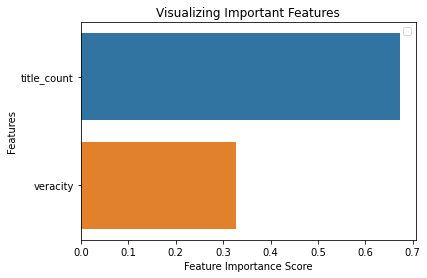

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

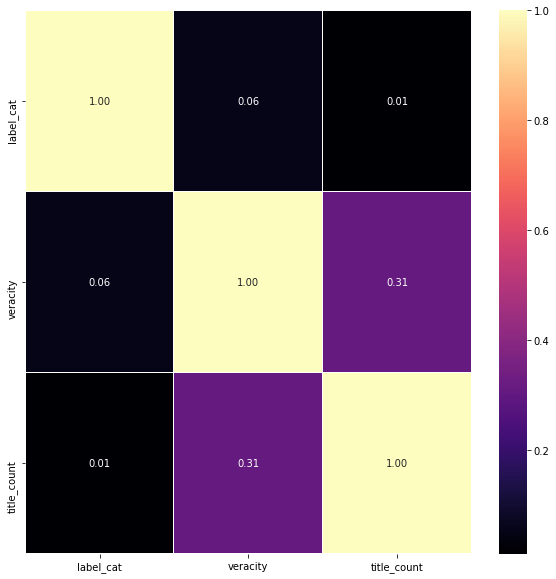

In [139]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_main.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

# Machine Learning Algorithm


In [140]:
#Import Libraries
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [141]:
col_names2 = ['veracity', 'title_count']
X_data_reshape = df_main[col_names2] # Features
y_data = df_main.label_cat # Target variable

Split the data into Training set and Test data

### Different Classifiers

In [142]:
from time import time
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


Create Train and Test data

In [143]:
X, y = X_data_reshape, y_data

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


### Muller Loop

Apply different classifiers to get the test scores and accuracy

# Accuracy Comparison

In [144]:
# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print(color.BOLD + color.BLUE + '########### Classifier Comparison ############\n\n' + color.END)
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print(color.BOLD + color.PURPLE + 'Classifier = %s, Accuracy Score = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time) + color.END)
    print('\n')
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(color.BOLD + color.BLUE + '\n\n##############################################################' + color.END)
print('\n\n')
print(color.BOLD + color.BLUE + 80*'-' + color.END)
print('\n\n')
print(color.BOLD + color.GREEN + 'Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score) + color.END)
print('\n\n')
#plot the output of the various algorithms

########### Classifier Comparison ############


Classifier = Nearest Neighbors, Accuracy Score = 19.02, Training time = 0.08 seconds


Classifier = Linear SVM, Accuracy Score = 25.43, Training time = 1.85 seconds


Classifier = RBF SVM, Accuracy Score = 27.33, Training time = 5.84 seconds


Classifier = Gaussian Process, Accuracy Score = 26.41, Training time = 2539.24 seconds


Classifier = Decision Tree, Accuracy Score = 27.48, Training time = 0.00 seconds


Classifier = Random Forest, Accuracy Score = 27.29, Training time = 0.03 seconds


Classifier = Neural Net, Accuracy Score = 25.33, Training time = 1.59 seconds


Classifier = AdaBoost, Accuracy Score = 26.99, Training time = 0.26 seconds


Classifier = Naive Bayes, Accuracy Score = 25.43, Training time = 0.00 seconds


Classifier = QDA, Accuracy Score = 25.43, Training time = 0.01 seconds




##############################################################



------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The test score and accuracy from different classifiers is shown above

# Pickle models

In [145]:
import pickle
from zipfile import ZipFile
import os

In [146]:
with ZipFile('/content/drive/My Drive/Alternus_Vera/Context_Veracity_Sprint5/models.zip', 'w') as myzip:
    for name, clf in zip(names, classifiers):
        pickle.dump(clf, open(f'{name}_model.pickle', 'wb'))
        myzip.write(f'{name}_model.pickle')
        os.remove(f'{name}_model.pickle')

# Conclusion

Reputation based source verification is not enough.

Only title text is analyzed in most cases not the entire story or article.

The so-called suspicious sources, however,
sometimes do publish facts and valid information, and reputable websites sometimes publish inaccu-rate information

Other websites such as Snopes / Buzz feed do not provide source information but rather post from FB in contrast to Politifact

## References

https://github.com/sfu-discourse-lab/MisInfoText
Github resource of the research paper "Where is your Evidence: Improving Fact-checking by Justification Modeling"

Research paper with Liar-Liar Plus dataset
https://www.aclweb.org/anthology/W18-5513.pdf

Research paper from the Fever Workshop
"The Data Challenge in Misinformation Detection:
Source Reputation vs. Content Veracity"

Also refered to other website such as "Snopes" and "FactCheck.org" to find source information for the news.

https://www.kaggle.com/mrisdal/fact-checking-facebook-politics-pages